## Week 6 Coding Video:  Generative Models

In this notebook we will create a bigram model of a famous children's book and use it to generate sentences. 

<div style="text-align: center;">
  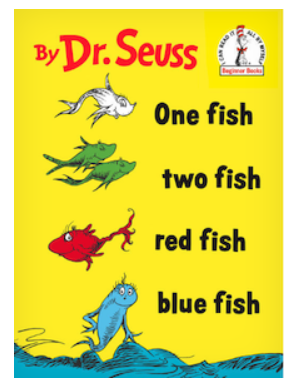
</div>

We will follow these standard steps:

- Using the common library `spacy`, we will tokenize the text string into tokens and sentences (lists of tokens)
- Add the beginning and ending tokens `<s> ... </s>`.
- Calculate the set of N-grams from the collection of all sentences.
- Create an N-gram PLM in the form of a dictionary mapping left context to the probability distribution of next words.
- Generate sentences using a bigram model and the simple algorithm presented at the end of the lesson.


In [1]:
# Useful imports

import math
import re
import string
import numpy as np
from tqdm import tqdm
import random
from matplotlib import pyplot as plt
from collections import Counter
import spacy

In [2]:
# Utility Code


def print_sentence(tokens):
    
    # Start with the first real token, capitalized
    output = tokens[1].capitalize()
    
    for t in tokens[2:-1]:
        if t in string.punctuation:
            # punctuation like ',', '.', '!' attaches with no space
            output += t
        elif t.startswith("'"):
            # tokens like "'s", "'d", "'ll" attach with no leading space
            output += t
        elif t in ['i','god']:
            output += ' ' + t.capitalize()
        else:
            # normal words get a space before them
            output += ' ' + t

    print(output)


### Load Text

We provide a sample for testing, consistent with the lesson, and the complete book for the actual demonstration. 

The complete text of two more books by Dr. Seuss are in Appendix Two. 

In [28]:
# text = "I am Sam. Sam I am. I do not like green eggs and ham."
text = "One fish Two fish Red fish Blue fish.  Black fish Blue fish Old fish New fish.  This one has a little star.  This one has a little car.  Say! What a lot  Of fish there are.  Yes. Some are red. And some are blue.  Some are old. And some are new.  Some are sad.  And some are glad.  And some are very, very bad.  Why are they  Sad and glad and bad?  I do not know.  Go ask your dad.  Some are thin.  And some are fat.  The fat one has  A yellow hat.  From there to here, from here to there,  Funny things  Are everywhere.  Here are some  Who like to run.  They run for fun  In the hot, hot sun.  Oh me! Oh my!  Oh me! Oh my!  What a lot  Of funny things go by.  Some have two feet  And some have four.  Some have six feet  And some have more.  Where do they come from? I can’t say.  But I bet they have come a long, long way.  We see them come.  We see them go.  Some are fast.  And some are slow.  Some are high  And some are low.  Not one of them  Is like another.  Don’t ask us why.  Go ask your mother.  Say!  Look at his fingers!  One, two, three...  How many fingers  Do I see?  One, two, three, four,  Five, six, seven,  Eight, nine, ten.  He has eleven!  Eleven!  This is something new.  I wish I had  Eleven, too! Bump! Bump! Bump! Did you ever ride a Wump? We have a Wump with just one hump. But we know a man called Mr. Gump. Mr. gump has a seven hump Wump. So... If you like to go Bump! Bump! Just jump on the hump of the Wump of Gump. Who am I? My name is Ned I do not like my little bed. This is no good. This is not right. My feet stick out of bed all night. And when I pull them in, Oh, Dear! My head sticks out of bed up here! We like our bike. It is made for three. Our Mike sits up in back, you see. We like our Mike, and this is why: Mike does all the work when the hills get high. Hello there, Ned. How do you do? Tell me, tell me what is new? How are things in your little bed? What is new? Please tell me Ned. I do not like this bed at all. A lot of things have come to call. A cow, a dog, a cat, a mouse. Oh! What a bed! Oh! What a house! Oh dear, oh dear! I cannot hear. Will you please come over near? Will you please look in my ear? There must be something there, I fear. Say look! A bird was in your ear. But he is out. So have no fear. Again your ear can hear, my dear. My hat is old, my teeth are gold. I have a bird I like to hold. My shoe is off, my foot is cold. My shoe is off, my foot is cold. I have a bird I like to hold. My hat is old, my teeth are gold. And now my story is all told. We took a look. We saw a Nook. On his head he had a hook. On his hook he had a book. On his book was 'How to Cook' We saw him sit and try to cook But a Nook can't read, so a Nook can't Cook. SO. What good to a Nook is a hook cook book? the moon was out and we saw some sheep. We saw some sheep take a walk in their sleep. by the light of the moon, by the light of a star; They walked all night from near to far. I would never walk. I would take a car. I do not like this one so well. all he does is yell, yell, yell. I will not have this one about. When he comes in I put him out. This one is quiet as a mouse. I like to have him in the house. At our house we open cans. We have to open many cans. and that is why we have a Zans. A Zans for cans is very good. Have you a Zans for cans? You should. I like to box. How I like to box. So every day I box a Gox. In yellow socks I box my Gox. I box in yellow Gox box socks. It is fun to sing if you sing with a Ying. My Ying can sing like anything. I sing high and my Ying sings low. And we are not too bad, you know. this one, I think, is called a Yink. he likes to wink, he likes to drink. He likes to drink, and drink, and drink. the thing he likes to drink is ink. The ink he likes to drink is pink. He likes to wink and drink pink ink. SO. If you have a lot of ink, you should get a Yink, I think. Hop, hop, hop! I am a Yop All I like to do is hop, From finger top to finger top. I hop from left to right and then... Hop, hop! I hop right back again. I like to hop all day and night. From right to left and left to right. Why do I like to hop, hop, hop? I do not know. Go ask your Pop. Brush, brush, brush, brush Comb, comb, comb, comb Blue hair is fun to brush and comb. All girls who like to brush and comb, Should have a pet like this at home. Who is this pet? Say! He is wet. You never yet met a pet, I bet, As wet as they let this wet pet get. Did you ever fly a kite in bed? did you ever walk with ten cats on your head? Did you ever milk this kind of cow? Well, we can do it. We know how. If you never did, you should. These things are fun, and fun is good. Hello, hello. Are you there? Hello! I called you up to say hello. I said Hello. Can you hear me, Joe? Oh no, I cannot hear your call. I cannot hear your call at all. This is not good, and I know why. A mouse has cut the wire, goodbye! From near to far, from here to there, Funny things are everywhere. These yellow pets are called the Zeds. They have one hair upon their heads. Their hair grows fast. So fast they say, They need a haircut every day. Who am I? My name is Ish On my hand I have a dish. I have this dish to help me wish. When I wish to make a wish I wave my hand with a big swish swish. Then I say, 'I wish for fish!' And I get fish right on my dish. So... If you wish to make a wish, you may swish for fish with my Ish wish dish. At our house we play out back. We play a game called ring the Gack. Would you like to play this game? Come down! We have the only Gack in town. Look what we found in the park in the dark. We will take him home, we will call him Clark. He will live at our house, he will grow and grow. Will our mother like this? We don't know. And now, Good night. It is time to sleep So we will sleep with our pet Zeep. Today is gone. Today was fun. Tomorrow is another one. Every day, from here to there. funny things are everywhere."
text

"One fish Two fish Red fish Blue fish.  Black fish Blue fish Old fish New fish.  This one has a little star.  This one has a little car.  Say! What a lot  Of fish there are.  Yes. Some are red. And some are blue.  Some are old. And some are new.  Some are sad.  And some are glad.  And some are very, very bad.  Why are they  Sad and glad and bad?  I do not know.  Go ask your dad.  Some are thin.  And some are fat.  The fat one has  A yellow hat.  From there to here, from here to there,  Funny things  Are everywhere.  Here are some  Who like to run.  They run for fun  In the hot, hot sun.  Oh me! Oh my!  Oh me! Oh my!  What a lot  Of funny things go by.  Some have two feet  And some have four.  Some have six feet  And some have more.  Where do they come from? I can’t say.  But I bet they have come a long, long way.  We see them come.  We see them go.  Some are fast.  And some are slow.  Some are high  And some are low.  Not one of them  Is like another.  Don’t ask us why.  Go ask your mo

In [4]:
len(text)

5899

### Create a Tokenizer using SPaCY

There are several good tokenizers available, `spacy` is a good default.
See Appendix One for more information about tokenizers and `spacy`. 

In [5]:
# Install spaCy and the small English model
# Uncomment and run this the first time
'''
!pip install -U spacy
!python -m spacy download en_core_web_sm
'''
;

''

In [6]:
# Load default English model
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 6000             # set to an integer larger than text length in characters

from spacy.symbols import ORTH
nlp.tokenizer.add_special_case("can't", [{ORTH: "can't"}])

# tokenize with spaCy

sentences = []

doc = nlp(text)

for sent in doc.sents:                                     # because spaCy sometimes inserts a blank token
    toks = ["<s>"] + [token.text.lower() for token in sent if not token.is_space] + ["</s>"]
    sentences.append(toks)



In [7]:
N = 5
print(f"There are {len(sentences)} sentences in the text. Here are {N} of them:\n")
for sent in sentences[:N]:
    print_sentence(sent)
    print()
    print(sent)
    print()

There are 209 sentences in the text. Here are 5 of them:

One fish two fish red fish blue fish.

['<s>', 'one', 'fish', 'two', 'fish', 'red', 'fish', 'blue', 'fish', '.', '</s>']

Black fish blue fish old fish new fish.

['<s>', 'black', 'fish', 'blue', 'fish', 'old', 'fish', 'new', 'fish', '.', '</s>']

This one has a little star.

['<s>', 'this', 'one', 'has', 'a', 'little', 'star', '.', '</s>']

This one has a little car.

['<s>', 'this', 'one', 'has', 'a', 'little', 'car', '.', '</s>']

Say!

['<s>', 'say', '!', '</s>']



#### A Little EDA....

In [8]:

# Flatten tokens (spaCy already tokenizes for us)
all_tokens = [tok.text.lower() for tok in doc]

# Define "word": alphabetic or alphabetic after removing internal apostrophes
def is_word(tok):
    s = tok.text
    return s.isalpha() or s.replace("'", "").isalpha()

words = [tok.text.lower() for tok in doc if is_word(tok)]

# Counts
print(f"Total number of characters in the text: {len(text):,}")
print(f"Total number of tokens:    {len(all_tokens):,}")
print(f"Number of unique tokens:   {len(set(all_tokens)):,}")
print(f"Total number of sentences: {len(list(doc.sents)):,}")
print(f"Total number of words:     {len(words):,}")
print(f"Number of unique words:    {len(set(words)):,}")

# Frequencies
word_counts = Counter(words)
most_common_words = word_counts.most_common()

# Top 10
print("\nTop 10 words:")
for token, freq in most_common_words[:10]:
    print(f"{token:<15}: {freq:,}")

# Bottom 10
print("\nBottom 10 words:")
for token, freq in most_common_words[-10:]:
    print(f"{token:<15}: {freq:,}")



Total number of characters in the text: 5,899
Total number of tokens:    1,648
Number of unique tokens:   301
Total number of sentences: 209
Total number of words:     1,297
Number of unique words:    290

Top 10 words:
a              : 51
i              : 51
to             : 40
is             : 36
and            : 32
are            : 26
my             : 25
we             : 25
you            : 24
like           : 21

Bottom 10 words:
found          : 1
park           : 1
dark           : 1
clark          : 1
live           : 1
n't            : 1
time           : 1
zeep           : 1
gone           : 1
tomorrow       : 1


#### The probability of sentence lengths is interesting and will be used in the homework!

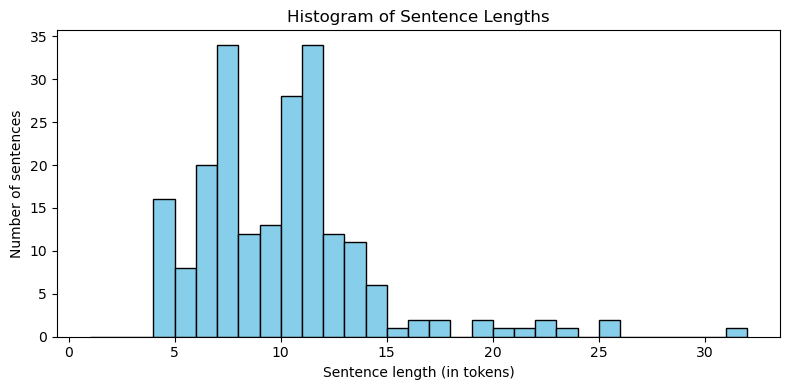

In [9]:
# Get sentence lengths
sentence_lengths = [len(sent) for sent in sentences]

# Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(sentence_lengths, bins=range(1, max(sentence_lengths)+2), color='skyblue',edgecolor='black')
plt.title("Histogram of Sentence Lengths")
plt.xlabel("Sentence length (in tokens)")
plt.ylabel("Number of sentences")
plt.tight_layout()
plt.show()


### Part One: Calculate the N-Grams

#### Part A: Calculate the N-grams

An N-gram is a tuple (so it can be stored in a dictionary):

        zerogram:     ()
        unigram:      ('One',)
        bigram:       ('One','fish')
        trigram       ('One','fish','two')

Here is a simple strategy for finding the N-grams. We'll create a dictionary of prefixes and lists of last words in N-grams:

- Scan  a "window" N words wide through each sentence to identify the N-grams (there will be (sent_length - N + 1) N-grams).
- Add each N-gram to a list.

In [10]:
# Take a sentence (a list of strings (tokens)) and return a list of all N-grams for a given N

def get_ngrams(sent, N):
    return [ tuple(sent[k:k+N]) for k in range(len(sent) - N + 1) ]

# test

print(sentences[0])
print("\nunigrams:")
print(get_ngrams(sentences[0],1))
print("\nbigrams:")
print(get_ngrams(sentences[0],2))
print("\ntrigrams:")
print(get_ngrams(sentences[0],3))

['<s>', 'one', 'fish', 'two', 'fish', 'red', 'fish', 'blue', 'fish', '.', '</s>']

unigrams:
[('<s>',), ('one',), ('fish',), ('two',), ('fish',), ('red',), ('fish',), ('blue',), ('fish',), ('.',), ('</s>',)]

bigrams:
[('<s>', 'one'), ('one', 'fish'), ('fish', 'two'), ('two', 'fish'), ('fish', 'red'), ('red', 'fish'), ('fish', 'blue'), ('blue', 'fish'), ('fish', '.'), ('.', '</s>')]

trigrams:
[('<s>', 'one', 'fish'), ('one', 'fish', 'two'), ('fish', 'two', 'fish'), ('two', 'fish', 'red'), ('fish', 'red', 'fish'), ('red', 'fish', 'blue'), ('fish', 'blue', 'fish'), ('blue', 'fish', '.'), ('fish', '.', '</s>')]


In [11]:
# Create list of all bigrams

bigrams = []
for sent in sentences:
    bigrams += get_ngrams(sent,2)

print(f"There are {len(bigrams)} total bigrams.")
print(f"There are {len(set(bigrams))} unique bigrams.")

There are 1799 total bigrams.
There are 1057 unique bigrams.


In [12]:
trigrams = []
for sent in sentences:
    trigrams += get_ngrams(sent,3)

print(f"There are {len(trigrams)} total trigrams.")
print(f"There are {len(set(trigrams))} unique trigrams.")

There are 1590 total trigrams.
There are 1315 unique trigrams.


### Part Two: Create a  Next Word Dictionary 

**Terminology:** The **left context** of an N-gram is a tuple of all but the last word. Examples:

    N      N-gram                    Left Context        Next Word
    -      ------                    ------------        ---------
    1      ("One",)                  ()                  "One"
    2      ("One", "fish")           ("One",)            "fish"
    3      ("One", "fish", "two")    ("One", "fish")     "two"         

We'll create a **dictionary mapping left contexts to a list of next words** (with possible duplicates).


In [30]:
# Take a list of N-grams and create a next-word dictionary

def get_next_word_dict(ngrams):
    dict = {}
    for ng in ngrams:
        lcontext = ng[:-1]
        next_word = ng[-1]
        dict[lcontext] = dict.get(lcontext, []) + [next_word]
    return dict

# test

# get_next_word_dict( bigrams )

In [14]:
# get_next_word_dict( trigrams )

### Part Three: Turn the Next Word Dictionary into a PLM

We will write two functions `tokens2probs` and `get_PLM` which will provide us with the probabilities that define our N-gram Probability Language Model (PLM)

In [15]:
# Turn list of tokens into a probability distribution dictionary
def tokens2probs(ws):
    k = len(ws)
    return { w : f/k  for (w,f) in Counter(ws).items() }

print(tokens2probs( [ 'and', 'then', 'and', 'when' ] ))      # should print      {'and': 0.5, 'then': 0.25, 'when': 0.25}

{'and': 0.5, 'then': 0.25, 'when': 0.25}


In [16]:
# Convert a next-word dictionary from contexts into a PLM = a dictionary 
# from left-contexts to a probability distribution of next words

def get_PLM(D):
    return { lcontext : tokens2probs(next_words)  for (lcontext,next_words) in D.items() }

In [17]:
Seuss_bigram = get_PLM( get_next_word_dict( bigrams ) ) 

# Test

# Seuss_bigram[('<s>',)]
Seuss_bigram[('house',)]

{'!': 0.2, '.': 0.2, 'we': 0.4, ',': 0.2}

In [18]:
Seuss_trigram = get_PLM( get_next_word_dict( trigrams ) ) 

# Test

# Seuss_trigram[('i','am')]
Seuss_trigram[('house','we')]

{'open': 0.5, 'play': 0.5}

### Part Four: Choosing Next Words and Generating Sentences using a Bigram PLM

It is quite simple to use our PLM to generate next words according to the probability distribution, 
as discussed in the lesson. 

We will use a bigram model, and you will extend this to a trigram model in the homework. 

The key operation in choosing the next word in a given context is to randomly choose from a list
according to a probability distribution. We will use `random.choices` to do this. 

In [19]:
random.choices(['a','b','c'], weights=[0.25,0.25,0.5],k=10)

['b', 'c', 'b', 'c', 'a', 'b', 'c', 'a', 'a', 'c']

In [20]:
def get_next_word(lcontext,plm):
    next_word_dist = plm[lcontext]         
    return random.choices( list(next_word_dist.keys()), weights = list(next_word_dist.values()) )[0]          

In [21]:
# Seuss_bigram[('house',)]

In [22]:
get_next_word(('house',),Seuss_bigram)

'we'

In [23]:
def get_sentence(plm,N=2):
    sentence = ['<s>']                             # Sentence is list of tokens
    while sentence[-1] != '</s>':
        lcontext  = tuple(sentence[-(N-1):])       # grab last N-1 tokens; left context must be a tuple
        next_word =  get_next_word(lcontext,plm)
        sentence.append(next_word)             
    return sentence
    
# Test
    
for _ in range(10):
    s = get_sentence(Seuss_bigram)
    # print(s)
    print_sentence( s  )
    print()


So ...

We know how are red fish old, by the only gack in yellow socks.

One is pink.

So every day.

Oh dear!

I do they need a hook he likes to drink.

I think.

My!

I hop, funny things are.

Oh me, good.



### Part Five: Making Choices with Temperature

So far, we’ve sampled the next word exactly according to its probability in context—more probable words are more likely to be chosen, but the process remains fully stochastic. However, we often want to **adjust the randomness** of this sampling. For example, we might want the model to make more confident predictions, or to explore less likely continuations. This is where **temperature sampling** becomes useful.

To incorporate **temperature sampling** into the `get_next_word` function, we need to adjust the next-word probabilities before sampling. A temperature parameter modifies the distribution like this:

$$
p_i^{\text{temp}} = \frac{p_i^{1/T}}{\sum_j p_j^{1/T}}
$$

Where:

* Lower temperature $T < 1$: sharpens the distribution (fewer but more confident choices).
* Higher temperature $T > 1$: flattens it (more choices, more exploratory, closer to a uniform distribution).
* $T = 1$: leaves the distribution unchanged.

Here is a function to apply a temperature to a list of probabilities, and an example showing how it works. 

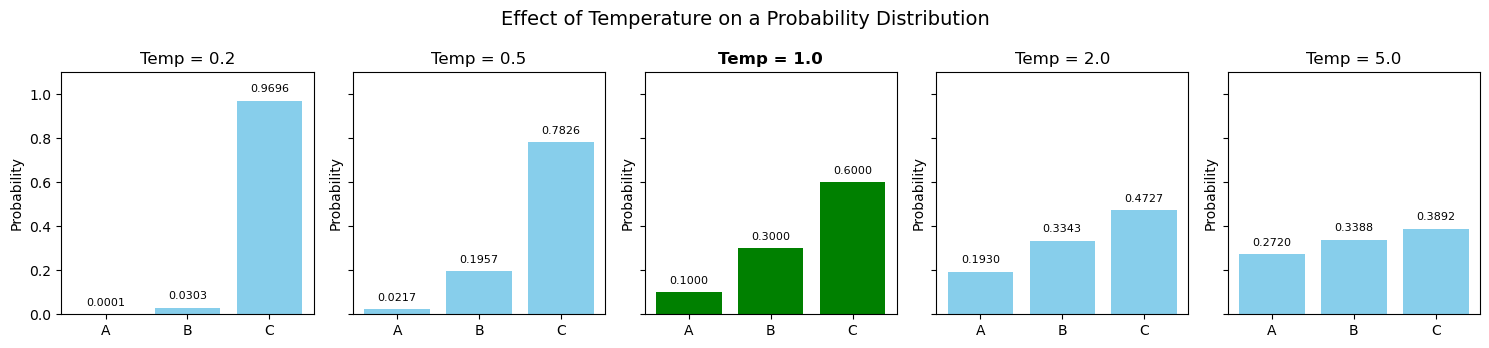

In [24]:

def apply_temperature_to_prob_list(probs, temperature=1.0):
    probs = np.array(probs, dtype=np.float64)
    probs = np.clip(probs, 1e-12, 1.0)          # avoid log(0)
    scaled = np.exp(np.log(probs) / temperature)
    return scaled / np.sum(scaled)

# ─── parameters ───────────────────────────────────────────────────────────
p       = [0.1, 0.3, 0.6]
labels  = ['A', 'B', 'C']
temps   = [0.2, 0.5, 1.0, 2.0, 5.0]

# ─── plotting ─────────────────────────────────────────────────────────────
fig, axs = plt.subplots(1, len(temps), figsize=(15, 3.5), sharey=True)

for ax, temp in zip(axs, temps):
    probs = apply_temperature_to_prob_list(p, temp)

    color = "green" if temp == 1.0 else "skyblue"
    bars  = ax.bar(labels, probs, color=color)

    # add value labels
    for bar, prob in zip(bars, probs):
        ax.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.03,          # slight offset above bar
                f"{prob:.4f}",
                ha="center", va="bottom", fontsize=8)

    fontweight = "bold" if temp == 1.0 else "normal"
    ax.set_title(f"Temp = {temp}",fontweight=fontweight)
    ax.set_ylim(0, 1.1)
    ax.set_ylabel("Probability")

fig.suptitle("Effect of Temperature on a Probability Distribution", fontsize=14)
fig.tight_layout()
plt.show()


#### Next Word and Sentence generation with Temperature

The **only** change we need to make is to add a parameter and modify the list of probabilities before choosing
the next word. 

In [25]:
def get_next_word_temp(lcontext,plm,temp=1.0):
    next_word_distribution = plm[lcontext]
    return random.choices( list(next_word_distribution.keys()), 
                           weights = apply_temperature_to_prob_list( list(next_word_distribution.values()), temp ) 
                         )[0] 
    return w 

def get_sentence_temp(plm,N=2,temp=1.0):
    sentence = ['<s>']                             # Sentence is list of tokens
    while sentence[-1] != '</s>':
        lcontext  = tuple(sentence[-(N-1):])       # left context must be a tuple
        next_word =  get_next_word_temp(lcontext,plm,temp)
        sentence.append(next_word)             
    return sentence
    


In [26]:
temperature = 3

for _ in range(10):
    s = get_sentence_temp(Seuss_bigram,temp=temperature)
    # print(s)
    print_sentence( s  )
    print()

Not right back, a lot of a bed?

Just one of the wump?

Come from near?

Who am I bet, so.

Well, and drink, goodbye!

From right on his head sticks out and some are called you a nook.

Are low.

And bad.

How many fingers do n’t ask us why are fat.

How I said hello, hop all the park in the dark.



## Appendix One: Using SpaCy

SpaCy is a popular open-source library for natural language processing (NLP). It provides fast, efficient tools for breaking down text and extracting linguistic information.

How SpaCy Works

spaCy uses pre-trained statistical models (such as `en_core_web_sm`) to analyze text. When you pass text into a pipeline, spaCy processes it through phases involving tokenization, part-of-speech tagging, lemmatization, and breaking into sentences. .

What You Can Extract

After running text through spaCy, you can access:

- Sentences – segmented spans of text.

- Tokens – words, punctuation, and symbols, each with attributes such as part of speech, lemma, and dependency role.

- Named Entities – people, places, organizations, dates, and other categories.

- Statistics – counts of tokens, vocabulary size, or frequency distributions.

In [27]:
import spacy
nlp = spacy.load("en_core_web_sm")
doc = nlp("SpaCy makes text analysis simple. It finds words, sentences, and more.")

print("Sentences:")
# Sentences
for k,sent in enumerate(doc.sents):
    print(f"Sentence {k}: {sent.text}")

# Tokens
print("\nTokens:")
print(f"{'Text':<15}{'POS':<10}{'Lemma'}")
print(f"{'-'*15}{'-'*10}{'-'*20}")

for token in doc:
    print(f"{token.text:<15}{token.pos_:<10}{token.lemma_}")


print("\nStatistics:")
# Basic counts
print("Total tokens:", len(doc))
print("Unique tokens:", len(set([token.text.lower() for token in doc if token.is_alpha])))
print("Sentences:", len(list(doc.sents)))

# Part-of-speech counts
pos_counts = doc.count_by(spacy.attrs.POS)
for k, v in pos_counts.items():
    print(doc.vocab[k].text, v)

# Most common words (excluding punctuation)
words = [token.text.lower() for token in doc if token.is_alpha]
print("\nTop words:", Counter(words).most_common(5))


Sentences:
Sentence 0: SpaCy makes text analysis simple.
Sentence 1: It finds words, sentences, and more.

Tokens:
Text           POS       Lemma
---------------------------------------------
SpaCy          PROPN     SpaCy
makes          VERB      make
text           NOUN      text
analysis       NOUN      analysis
simple         ADJ       simple
.              PUNCT     .
It             PRON      it
finds          VERB      find
words          NOUN      word
,              PUNCT     ,
sentences      NOUN      sentence
,              PUNCT     ,
and            CCONJ     and
more           ADJ       more
.              PUNCT     .

Statistics:
Total tokens: 15
Unique tokens: 11
Sentences: 2
PROPN 1
VERB 2
NOUN 4
ADJ 2
PUNCT 4
PRON 1
CCONJ 1

Top words: [('spacy', 1), ('makes', 1), ('text', 1), ('analysis', 1), ('simple', 1)]


## Appendix Two: Two More Seuss Books

## "GREEN EGGS AND HAM" (by Doctor Seuss) 


I am Sam. I am Sam. Sam I am.

That Sam-I-am! That Sam-I-am! I do not like that Sam-I-am!

Do you like green eggs and ham?

I do not like them, Sam-I-am. I do not like green eggs and ham.

Would you like them here or there?

I would not like them here or there. I would not like them anywhere. I do not like green eggs and ham. I do not like them, Sam-I-am.

Would you like them in a house? Would you like them with a mouse?

I do not like them in a house. I do not like them with a mouse. I do not like them here or there. I do not like them anywhere. I do not like green eggs and ham. I do not like them, Sam-I-am.

Would you eat them in a box? Would you eat them with a fox?

Not in a box. Not with a fox. Not in a house. Not with a mouse. I would not eat them here or there. I would not eat them anywhere. I would not eat green eggs and ham. I do not like them, Sam-I-am.

Would you? Could you? In a car? Eat them! Eat them! Here they are.

I would not, could not, in a car.

You may like them. You will see.
You may like them in a tree!

I would not, could not in a tree.
Not in a car! You let me be.
I do not like them in a box.
I do not like them with a fox.
I do not like them in a house.
I do not like them with a mouse.
I do not like them here or there.
I do not like them anywhere.
I do not like green eggs and ham.
I do not like them, Sam-I-am.

A train! A train! A train! A train!
Could you, would you on a train?

Not on a train! Not in a tree!
Not in a car! Sam! Let me be!
I would not, could not, in a box.
I would not, could not, with a fox.
I will not eat them in a house.
I will not eat them here or there.
I will not eat them anywhere.
I do not eat green eggs and ham.
I do not like them, Sam-I-am.

Say! In the dark? Here in the dark!
Would you, could you, in the dark?

I would not, could not, in the dark.

Would you, could you, in the rain?

I would not, could not in the rain.
Not in the dark. Not on a train.
Not in a car. Not in a tree.
I do not like them, Sam, you see.
Not in a house. Not in a box.
Not with a mouse. Not with a fox.
I will not eat them here or there.
I do not like them anywhere!

You do not like green eggs and ham?

I do not like them, Sam-I-am.

Could you, would you, with a goat?

I would not, could not with a goat!

Would you, could you, on a boat?

I could not, would not, on a boat.
I will not, will not, with a goat.
I will not eat them in the rain.
Not in the dark! Not in a tree!
Not in a car! You let me be!
I do not like them in a box.
I do not like them with a fox.
I will not eat them in a house.
I do not like them with a mouse.
I do not like them here or there.
I do not like them anywhere!
I do not like green eggs and ham!
I do not like them, Sam-I-am.

You do not like them. So you say.
Try them! Try them! And you may.
Try them and you may, I say.

Sam! If you let me be,
I will try them. You will see.



Say! I like green eggs and ham!
I do! I like them, Sam-I-am!
And I would eat them in a boat.
And I would eat them with a goat...
And I will eat them, in the rain.
And in the dark. And on a train.
And in a car. And in a tree.
They are so good, so good, you see!
So I will eat them in a box.
And I will eat them with a fox.
And I will eat them in a house.
And I will eat them with a mouse.
And I will eat them here and there.
Say! I will eat them anywhere!
I do so like green eggs and ham!
Thank you! Thank you, Sam I am.

## Oh, the Places You'll Go

Congratulations!
Today is your day.
You're off to Great Places!
You're off and away!

You have brains in your head.
You have feet in your shoes.
You can steer yourself
any direction you choose.
You're on your own. And you know what you know.
And YOU are the guy who'll decide where to go.

You'll look up and down streets. Look 'em over with care.
About some you will say, "I don't choose to go there."
With your head full of brains and your shoes full of feet,
you're too smart to go down any not-so-good street.

And you may not find any
you'll want to go down.
In that case, of course,
you'll head straight out of town.

It's opener there
in the wide open air.

Out there things can happen
and frequently do
to people as brainy
and footsy as you.

And then things start to happen,
don't worry. Don't stew.
Just go right along.
You'll start happening too.

OH!
THE PLACES YOU'LL GO!

You'll be on y our way up!
You'll be seeing great sights!
You'll join the high fliers
who soar to high heights.

You won't lag behind, because you'll have the speed.
You'll pass the whole gang and you'll soon take the lead.
Wherever you fly, you'll be best of the best.
Wherever you go, you will top all the rest.

Except when you don't.
Because, sometimes, you won't.

I'm sorry to say so
but, sadly, it's true
that Bang-ups
and Hang-ups
can happen to you.

You can get all hung up
in a prickle-ly perch.
And your gang will fly on.
You'll be left in a Lurch.

You'll come down from the Lurch
with an unpleasant bump.
And the chances are, then,
that you'll be in a Slump.

And when you're in a Slump,
you're not in for much fun.
Un-slumping yourself
is not easily done.

You will come to a place where the streets are not marked.
Some windows are lighted. But mostly they're darked.
A place you could sprain both your elbow and chin!
Do you dare to stay out? Do you dare to go in?
How much can you lose? How much can you win?

And IF you go in, should you turn left or right...
or right-and-three-quarters? Or, maybe, not quite?
Or go around back and sneak in from behind?
Simple it's not, I'm afraid you will find,
for a mind-maker-upper to make up his mind.

You can get so confused
that you'll start in to race
down long wiggled roads at a break-necking pace
and grind on for miles cross weirdish wild space,
headed, I fear, toward a most useless place.
The Waiting Place...

...for people just waiting.
Waiting for a train to go
or a bus to come, or a plane to go
or the mail to come, or the rain to go
or the phone to ring, or the snow to snow
or the waiting around for a Yes or No
or waiting for their hair to grow.
Everyone is just waiting.

Waiting for the fish to bite
or waiting for the wind to fly a kite
or waiting around for Friday night
or waiting, perhaps, for their Uncle Jake
or a pot to boil, or a Better Break
or a string of pearls, or a pair of pants
or a wig with curls, or Another Chance.
Everyone is just waiting.

NO!
That's not for you!

Somehow you'll escape
all that waiting and staying
You'll find the bright places
where Boom Bands are playing.

With banner flip-flapping,
once more you'll ride high!
Ready for anything under the sky.
Ready because you're that kind of a guy!

Oh, the places you'll go! There is fun to be done!
There are points to be scored. There are games to be won.
And the magical things you can do with that ball
will make you the winning-est winner of all.
Fame! You'll be as famous as famous can be,
with the whole wide world watching you win on TV.

Except when they don't
Because, sometimes they won't.

I'm afraid that some times
you'll play lonely games too.
Games you can't win
'cause you'll play against you.

All Alone!
Whether you like it or not,
Alone will be something
you'll be quite a lot.

And when you're alone, there's a very good chance
you'll meet things that scare you right out of your pants.
There are some, down the road between hither and yon,
that can scare you so much you won't want to go on.

But on you will go
though the weather be foul.
On you will go
though your enemies prowl.
On you will go
though the Hakken-Kraks howl.
Onward up many
a frightening creek,
though your arms may get sore
and your sneakers may leak.

On and on you will hike,
And I know you'll hike far
and face up to your problems
whatever they are.

You'll get mixed up, of course,
as you already know.
You'll get mixed up
with many strange birds as you go.
So be sure when you step.
Step with care and great tact
and remember that Life's
a Great Balancing Act.
Just never foget to be dexterous and deft.
And never mix up your right foot with your left.

And will you succeed?
Yes! You will, indeed!
(98 and 3/4 percent guaranteed.)

KID, YOU'LL MOVE MOUNTAINS!

So...
be your name Buxbaum or Bixby or Bray
or Mordecai Ali Van Allen O'Shea,
You're off the Great Places!
Today is your day!
Your mountain is waiting.
So...get on your way!

## OPTIONAL:  Part Six: Nucleus Sampling (top-p)

In our previous section, we explored **temperature**, a knob that reshapes the probability distribution of the next token, making the model more or less “creative.”  
Now we turn to another important decoding strategy: **nucleus sampling**, controlled by the parameter **`top_p`**.

Instead of keeping a fixed number of candidate tokens (as in top-k), nucleus sampling selects the *smallest set of tokens whose cumulative probability mass exceeds `p`*.  
- If the model is very confident (one token dominates), only a few options will be considered.  
- If the distribution is flatter (many plausible tokens), more candidates will be included.  

This makes nucleus sampling **adaptive**: the number of possible next words changes depending on the model’s certainty. By renormalizing probabilities within this “nucleus,” we ensure that low-probability words — which are often just random noise — are excluded, while still allowing diversity when the model is genuinely uncertain.  

In practice, values of `top_p` between **0.8 and 0.95** are common, meaning the least common **5–20%** of words are excluded. Smaller values keep the output focused but risk dullness; larger values allow more diversity but can drift into incoherence.  

    


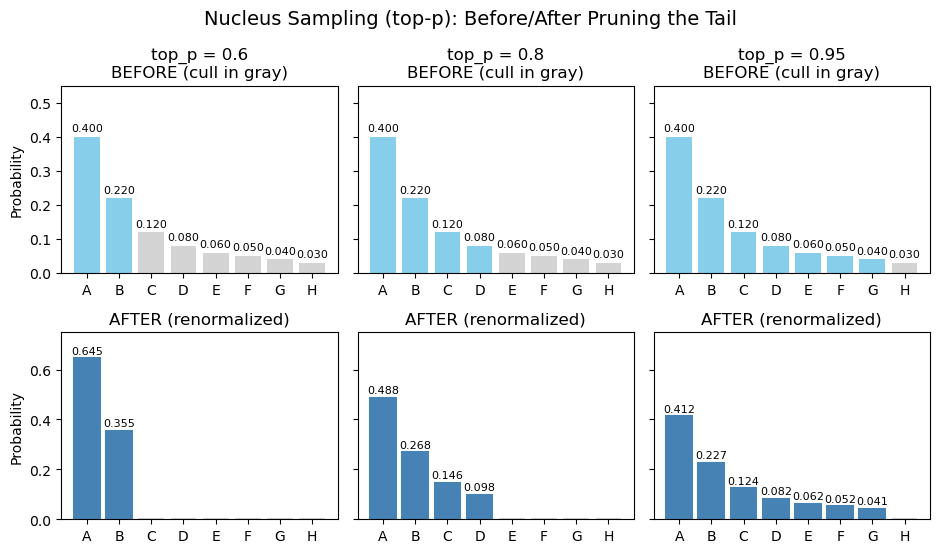

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def apply_top_p_nucleus(probs, top_p=0.9):
    """
    Return (renormalized_probs, keep_mask) after nucleus pruning.
    - probs: list/array of token probabilities that sum to 1.
    - top_p: keep the smallest set whose cumulative mass >= top_p.
    """
    probs = np.array(probs, dtype=np.float64)
    probs = probs / probs.sum()  # safety

    # sort indices by descending prob
    order = np.argsort(-probs)
    cum = np.cumsum(probs[order])

    # smallest prefix whose cumulative mass >= top_p
    cutoff_idx = np.searchsorted(cum, top_p, side="left")
    keep_sorted_idx = order[:cutoff_idx+1] if len(order) > 0 else order

    # build mask in original order
    keep_mask = np.zeros_like(probs, dtype=bool)
    keep_mask[keep_sorted_idx] = True

    # renormalize over kept tokens
    kept_mass = probs[keep_mask].sum()
    renorm = np.zeros_like(probs)
    if kept_mass > 0:
        renorm[keep_mask] = probs[keep_mask] / kept_mass

    return renorm, keep_mask

# ─── example distribution ─────────────────────────────────────────────────
labels = list("ABCDEFGH")
p = np.array([0.40, 0.22, 0.12, 0.08, 0.06, 0.05, 0.04, 0.03])
p = p / p.sum()

top_ps = [0.6, 0.8, 0.95]

# ─── plotting ─────────────────────────────────────────────────────────────
n_cols = len(top_ps)
fig, axs = plt.subplots(2, n_cols, figsize=(2.5*n_cols + 2, 5.6), sharey='row')

for j, tp in enumerate(top_ps):
    renorm, keep_mask = apply_top_p_nucleus(p, top_p=tp)

    # BEFORE: original probs, culled = light gray
    ax_before = axs[0, j]
    colors_before = ["skyblue" if keep else "lightgray" for keep in keep_mask]
    bars_before = ax_before.bar(labels, p, color=colors_before)
    for bar, prob in zip(bars_before, p):
        ax_before.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01,
                       f"{prob:.3f}", ha="center", va="bottom", fontsize=8)
    ax_before.set_title(f"top_p = {tp}\nBEFORE (cull in gray)")
    ax_before.set_ylim(0, max(0.55, p.max()+0.1))
    if j == 0:
        ax_before.set_ylabel("Probability")

    # AFTER: renormalized over kept tokens only
    ax_after = axs[1, j]
    colors_after = ["steelblue" if keep else "white" for keep in keep_mask]
    edgecolors = ["steelblue" if keep else "lightgray" for keep in keep_mask]
    bars_after = ax_after.bar(labels, renorm, color=colors_after, edgecolor=edgecolors, linewidth=1.5)
    for bar, prob in zip(bars_after, renorm):
        if prob > 0:
            ax_after.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01,
                          f"{prob:.3f}", ha="center", va="bottom", fontsize=8)
    ax_after.set_title("AFTER (renormalized)")
    ax_after.set_ylim(0, max(0.75, renorm.max()+0.1))
    if j == 0:
        ax_after.set_ylabel("Probability")

fig.suptitle("Nucleus Sampling (top-p): Before/After Pruning the Tail", fontsize=14)
fig.tight_layout()
plt.show()


In [ ]:
import numpy as np
import random

def apply_temperature_to_prob_list(probs, temperature=1.0):
    """Scale a probability list by temperature and renormalize."""
    probs = np.array(probs, dtype=np.float64)
    probs = np.clip(probs, 1e-12, 1.0)                 # avoid log(0)
    scaled = np.exp(np.log(probs) / max(1e-6, temperature))
    return (scaled / scaled.sum()).tolist()

def apply_top_p_nucleus(probs, top_p=0.9):
    """
    Keep the smallest set of tokens whose cumulative mass >= top_p.
    Returns a new prob list (same length) where dropped tokens get prob=0,
    and the kept ones are renormalized to sum to 1.
    """
    probs = np.array(probs, dtype=np.float64)
    probs = probs / probs.sum()
    order = np.argsort(-probs)                 # descending
    cum   = np.cumsum(probs[order])

    cutoff_idx = np.searchsorted(cum, top_p, side="left")
    keep_idx_sorted = order[:cutoff_idx+1] if len(order) else order

    keep_mask = np.zeros_like(probs, dtype=bool)
    keep_mask[keep_idx_sorted] = True

    kept_mass = probs[keep_mask].sum()
    out = np.zeros_like(probs)
    if kept_mass > 0:
        out[keep_mask] = probs[keep_mask] / kept_mass
    else:
        # fallback: keep argmax
        argmax = int(np.argmax(probs))
        out[argmax] = 1.0
    return out.tolist()

def get_next_word_temp_top_p(lcontext, plm, temp=1.0, top_p=0.9):
    """
    Sample next word using temperature + top_p (nucleus) on the context distribution.
    - plm[lcontext] is a dict: token -> probability (unnormalized OK).
    """
    next_word_distribution = plm[lcontext]                 # dict[token] -> prob
    tokens = list(next_word_distribution.keys())
    probs  = list(next_word_distribution.values())

    # 1) temperature
    probs_t = apply_temperature_to_prob_list(probs, temperature=temp)
    # 2) nucleus pruning + renormalization
    probs_tp = apply_top_p_nucleus(probs_t, top_p=top_p)

    # 3) sample
    return random.choices(tokens, weights=probs_tp, k=1)[0]

def get_sentence_temp_top_p(plm, N=2, temp=1.0, top_p=0.9, max_len=200):
    """
    Generate tokens until </s>, using N-gram context with temp + top_p sampling.
    """
    sentence = ['<s>']
    while sentence[-1] != '</s>' and len(sentence) < max_len:
        lcontext = tuple(sentence[-(N-1):]) if N > 1 else tuple()
        # basic fallback if context unseen
        if lcontext not in plm:
            # try backing off; finally fall back to a special context if provided
            backoff = lcontext[1:] if len(lcontext) > 0 else lcontext
            while backoff not in plm and len(backoff) > 0:
                backoff = backoff[1:]
            if backoff in plm:
                lcontext = backoff
            elif ('<s>',) in plm:
                lcontext = ('<s>',)
            else:
                lcontext = random.choice(list(plm.keys()))
        next_word = get_next_word_temp_top_p(lcontext, plm, temp=temp, top_p=top_p)
        sentence.append(next_word)
    return sentence


In [ ]:
temperature = 3

for _ in range(10):
    s = get_sentence_temp(Seuss_bigram,temp=temperature)
    # print(s)
    print_sentence( s  )
    print()